## 4. Weather and Foursquare Location Data Analysis

In [90]:
# data processing
import pandas as pd 
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# database agent
import psycopg2
from psycopg2 import OperationalError, errorcodes, errors

# calculate distance from coordinates
from geopy.distance import geodesic as GD

# env variables
import os
from dotenv import load_dotenv
load_dotenv()
database_credentials = {
    "username": os.getenv("DB_USERNAME"),
    "password": os.getenv("DB_PASSWORD")
}

# sys to add parent folder to path
import sys
sys.path.append("..")

from src.support_database_connection import connect_to_database

Now that the data has been loaded to the database, the goal is to analyse with the purpose of discovering insights that of impact to the business

## 4.1 Business case

Our organization is setting up a summer gymkana with the summer camp kids from the Community of Madrid. We are looking for a big space like a park, to set up the contests. Ideally, it should be a beautiful day with good weather, but not too hot. In the case of excessive heat, we could look for activities around to take the kids and still have fun while avoiding heat syncopes.

### 4.1.1 Find parks

First, let's evaluate how many parks there are available.

In [91]:
connection = connect_to_database("modulo4_lab3",credentials_dict=database_credentials)
cursor = connection.cursor()

From the total of foursquare locations, more than 80% are parks. That starts making things easy.

In [92]:
cursor.execute("SELECT SUM(CASE WHEN category='Park' THEN 1 ELSE 0 END), COUNT(*) FROM foursquare_location;")
pd.DataFrame(cursor.fetchall(), columns=["parques","total_localizaciones"])

,parques,total_localizaciones
0,663,822


### 4.1.2 Find what parks have a good weather

There were 2 criteria for determining what good weather means for our gymkana:
- A clear sky
- Not excessive heat

The first one can be quite straight-forward. However, taking into account that this activity will be carried out in end August, excessive heat will be tricky to avoid. 

To find a clear sky, let's re-check the categories for cielo to find the most interesting for our activity:

In [93]:
cursor.execute("SELECT DISTINCT cielo FROM weather;")
pd.DataFrame(cursor.fetchall())

,0
0,Cubierto con lluvia
1,Nuboso con lluvia
2,Poco nuboso
3,Nuboso con lluvia escasa
4,Intervalos nubosos con lluvia escasa
5,Cielo despejado
6,Nubes altas
7,Bruma
8,Nuboso con tormenta y lluvia escasa
9,Cubierto


The weather categories that is desirable for us is; 'Cielo despejado'. Thus, let's find which parks have mostly 'Cielo despejado' as a sky state.

First, lest check what percentage of parks have a clear sky:

In [94]:
cursor.execute("""SELECT CASE WHEN category='Park' THEN 'Park' 
                            ELSE 'Not a park' END,
                            CASE WHEN cielo='Cielo despejado' THEN 'Despejado' 
                            ELSE 'Not despejado' END, COUNT(*) 
               FROM foursquare_location fl
               INNER JOIN weather w 
                    ON w.id_municipio = fl.id_municipio
               GROUP BY CASE WHEN category='Park' THEN 'Park' 
                            ELSE 'Not a park' END,
                            CASE WHEN cielo='Cielo despejado' THEN 'Despejado' 
                            ELSE 'Not despejado' END;""")
pd.DataFrame(cursor.fetchall())

,0,1,2
0,Not a park,Not despejado,6194
1,Not a park,Despejado,805
2,Park,Not despejado,26364
3,Park,Despejado,2903


The data does not allow for us to quickly see this as the numbers seen on the screen represent hourly data across approximatedly 2 days, thus it is better to see which parks have a majority of clear sky states throughout the day.

In [95]:
cursor.execute("""SELECT location_name, municipio, m.id_municipio
                    FROM foursquare_location fl 
                    INNER JOIN municipios m 
                         ON m.id_municipio = fl.id_municipio
                    WHERE 
                              (SELECT cielo
                              FROM foursquare_location fl_sub
                              INNER JOIN weather w_sub
                                   ON fl_sub.id_municipio = w_sub.id_municipio
                              WHERE fl_sub.fsq_id = fl.fsq_id
                              GROUP BY location_name, cielo
                              ORDER BY COUNT(*) DESC
                              LIMIT 1) = 'Cielo despejado'
                              AND category = 'Park';""")
pd.DataFrame(cursor.fetchall(), columns=["Location_name","town","id_municipio"])

,Location_name,town,id_municipio
0,Parque Tierno Galván,San Martín de la Vega,id28132
1,Parque de la Estacion,San Martín de Valdeiglesias,id28133
2,El Bosque Encantado,San Martín de Valdeiglesias,id28133
3,Parque Central,Tres Cantos,id28903
4,Parque Antonio López,Tres Cantos,id28903
5,Parque Infantil Literatos 1,Tres Cantos,id28903
6,Parque Central Tres Cantos,Tres Cantos,id28903
7,Bike Park Tres Cantos,Tres Cantos,id28903
8,Parque infantil del castillo,Tres Cantos,id28903
9,Parque Infantil Descubridores 1,Tres Cantos,id28903


Tres Cantos quickly stands out, being the top town of the list. This is probably due to that city having many parks registered in foursquare, and having had a clear day weather forecast for our data.

Let's check its temperature distribution throughout the day:

In [96]:
cursor.execute("""SELECT fecha, temp_celsius, sen_termica_celsius, municipio
                    FROM weather w
                    INNER JOIN municipios m 
                        ON m.id_municipio = w.id_municipio
                    WHERE w.id_municipio IN ('id28903','id28133','id28132')""")
hourly_temp_tres_cantos = pd.DataFrame(cursor.fetchall(), columns=["fecha_hora","temp_celsius","sensacion_termica_celsius","municipio"])

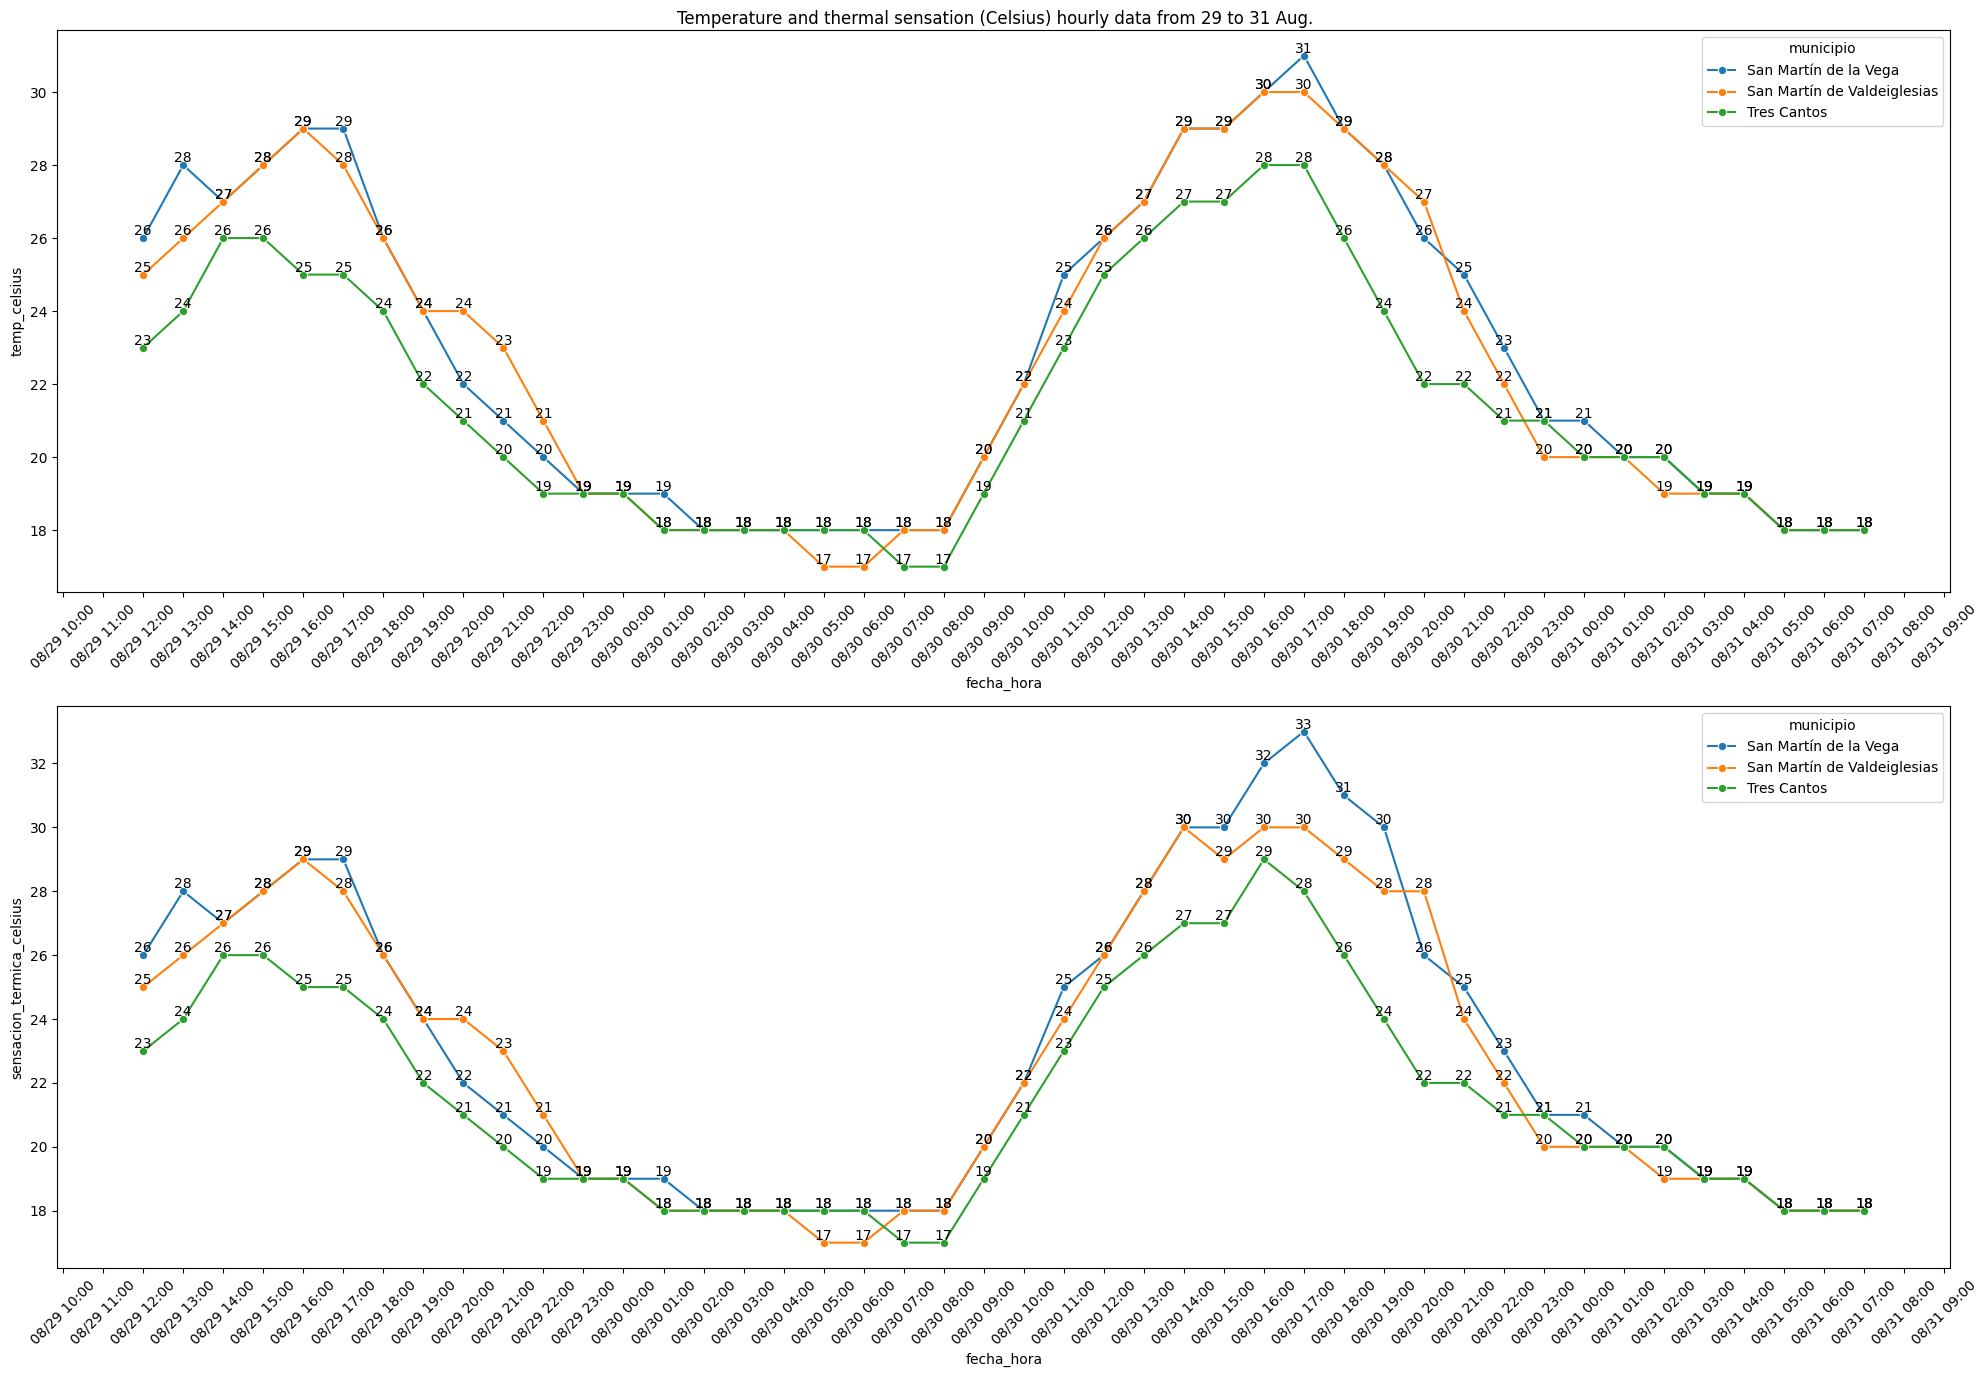

In [97]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 14)) 

fig.suptitle("Temperature and thermal sensation (Celsius) hourly data from 29 to 31 Aug.")

##First plot
sns.lineplot(data=hourly_temp_tres_cantos,
             x="fecha_hora",
             y="temp_celsius",
             marker="o",
             hue="municipio",
             ax=ax1)

# adding data labels
for line in ax1.lines:
    for x_data, y_data in zip(line.get_xdata(), line.get_ydata()):
        ax1.text(x_data, y_data, f'{y_data:.0f}', ha='center', va='bottom')

# show hourly xticks
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:00'))
ax1.tick_params(axis='x', rotation=45)


## Second plot
sns.lineplot(data=hourly_temp_tres_cantos,
             x="fecha_hora",
             y="sensacion_termica_celsius",
             marker="o",
             hue="municipio",
             ax=ax2)

# adding data labels
for line in ax2.lines:
    for x_data, y_data in zip(line.get_xdata(), line.get_ydata()):
        ax2.text(x_data, y_data, f'{y_data:.0f}', ha='center', va='bottom')

# show hourly xticks
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:00'))
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


It is great, because tres cantos has the lowest temperature and thermal sensation of the 3 towns with a clear sky. Let's also check if there will be some breeze of air, a light wind, to refresh the kids while they run.



In [98]:
cursor.execute("""SELECT fecha, velocidad_viento, municipio
                    FROM weather w
                    INNER JOIN municipios m 
                        ON m.id_municipio = w.id_municipio
                    WHERE w.id_municipio IN ('id28903','id28133','id28132')""")
hourly_wind_tres_cantos = pd.DataFrame(cursor.fetchall(), columns=["fecha_hora","velocidad_viento","municipio"])

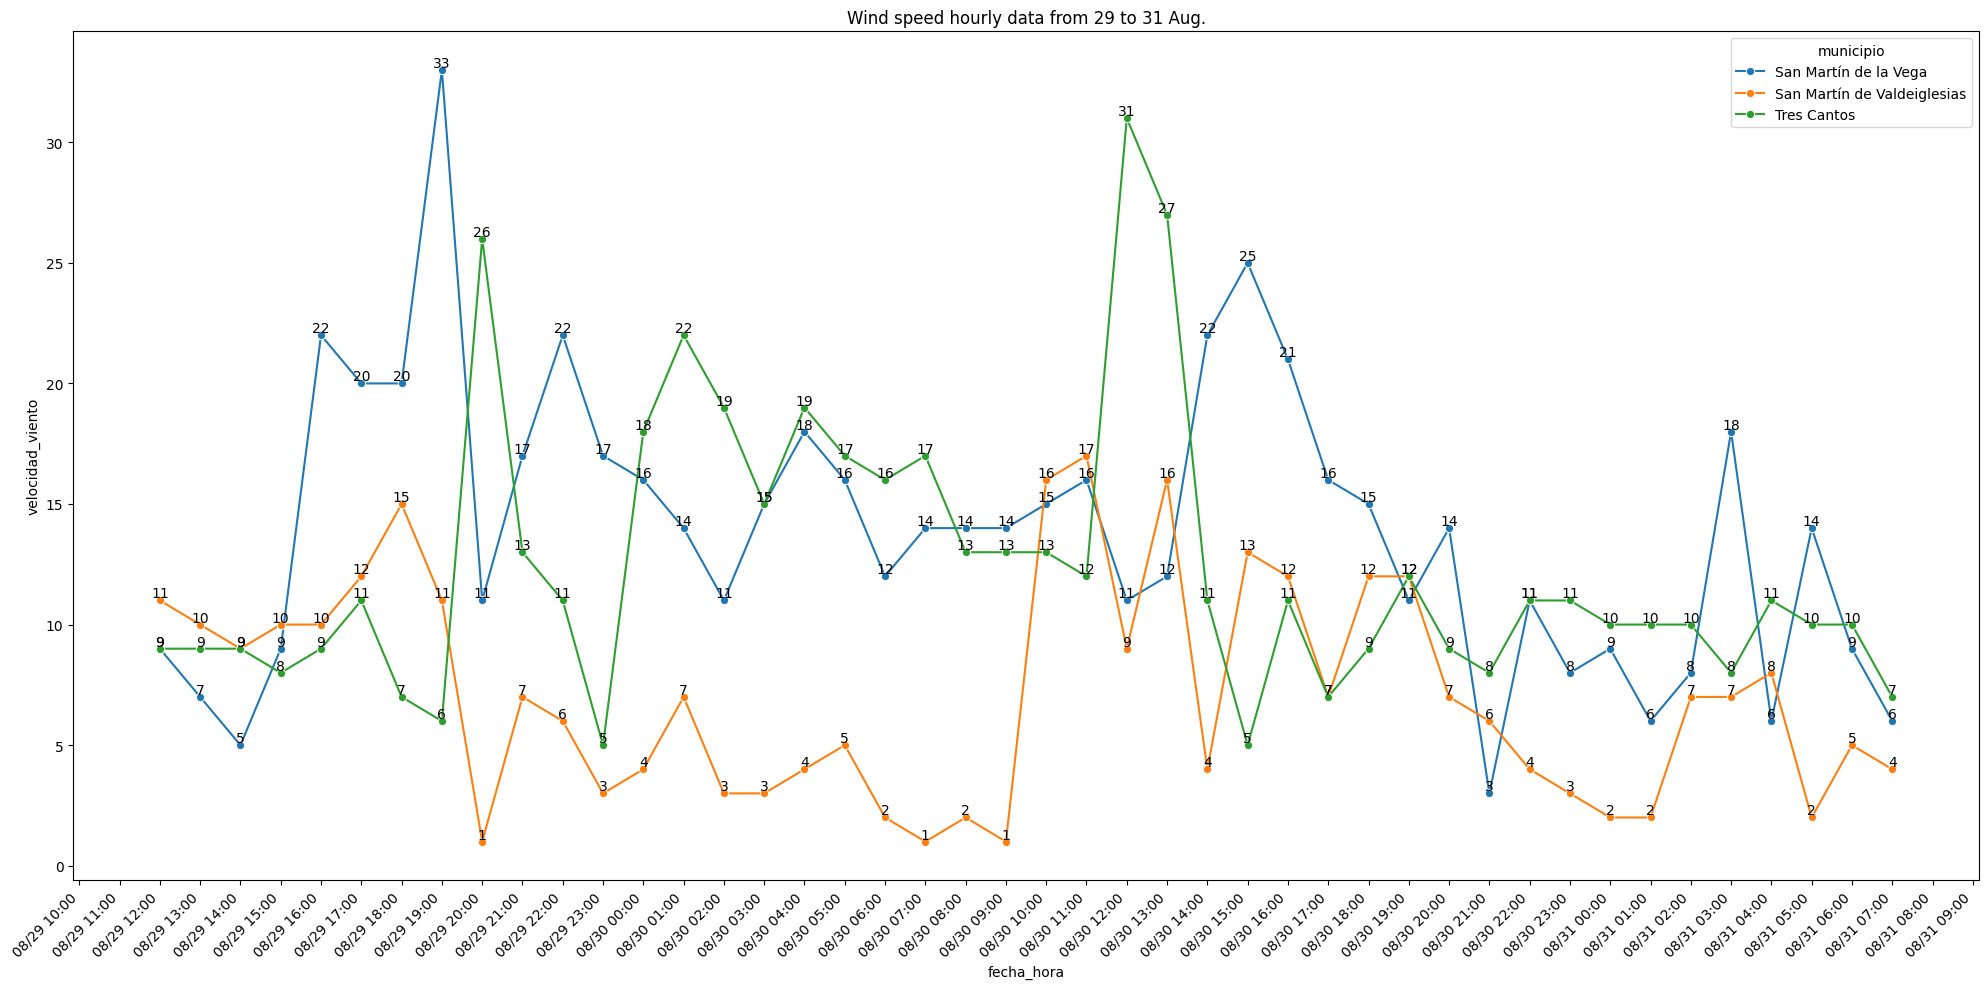

In [99]:
fig, ax = plt.subplots(figsize=(20,10))

plt.title("Wind speed hourly data from 29 to 31 Aug.")

# plotting the hourly data
sns.lineplot(data=hourly_wind_tres_cantos,
             x="fecha_hora",
             y="velocidad_viento",
             marker="o",
             hue="municipio",
             ax=ax)

# acessing line plot data points
for line in ax.lines:
    for x_data, y_data in zip(line.get_xdata(), line.get_ydata()):
        ax.text(x_data, y_data, f'{y_data:.0f}', ha='center', va='bottom')

# writing the xticks hourly
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:00'))

plt.tight_layout()
plt.show()

The wind distribution seems more stable and moderate for tres cantos after 2PM, and might alleviate the heat a bit,. Before that, the wind speed might be too high and could interefere with the Gymkana.The above graph can get too overwhelming, so let's calculate the average wind speed per these municipios between noon and 6PM.

In [103]:
cursor.execute("""
    SELECT municipio, ROUND(AVG(velocidad_viento),2), ROUND(STDDEV(velocidad_viento),2)
    FROM weather w
    INNER JOIN municipios m 
        ON m.id_municipio = w.id_municipio
    WHERE w.id_municipio IN ('id28903', 'id28133', 'id28132')
    AND fecha BETWEEN '2024-08-30 14:00:00' AND '2024-08-30 18:00:00'
    GROUP BY municipio
""") 

pd.DataFrame(cursor.fetchall(), columns=["municipio","avg_velocidad_viento","std_velocidad_viento"]) 

,municipio,avg_velocidad_viento,std_velocidad_viento
0,San Martín de la Vega,19.80,4.21
1,San Martín de Valdeiglesias,9.60,3.91
2,Tres Cantos,8.60,2.61


As seen in the graph, the average wind speed for Tres Cantos is a bit smaller and also more stable after 2PM.

Nonetheless, just to be sure, it will be convenient to find activities close to the park, within a radius of max 1km in case it gets too hot. So from then on, it will be a matter of finding the park from all those that are available in Tres Cantos, that has the most or most interesting activities around as an alternative.